### Import data

In [1]:
include("importData.jl")
include("Hill.jl")
include("plot.jl")

param_lap_dde = CSV.read(joinpath("..", "data", "params_lap_DDE.csv"))
conc = [param_lap_dde[8,col] for col in 2:9]

# import G1, G2, and population data
pop, g2, g1, g2_0, g1_0 = get_data(joinpath("..", "data", "lap.csv"),
                                   joinpath("..", "data", "lap_pop.csv"));
# removing peaks from the data
for i in 1:length(conc)
    pop[:, i] = remove_peaks(pop[:, i])
    g2[:, i] = remove_peaks(g2[:, i])
    g1[:, i] = remove_peaks(g1[:, i])
end

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:30
└ @ Main /home/farnazm/dde/enhance/DrugResponseModel.jl/src/importData.jl:30
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[1]:13
└ @ Core ./In[1]:13


### Hill model, residual functions and optimization

In [12]:
#  [EC50, b_steepness, alpha_min, alpha_max, beta_min, beta_max, tau1_mean, tau1_max, tau2_min, tau2_max, gamma1_max, gamma2_max]
# guess
# guess = [100.0, 0.001 , 0.007, 0.01, 0.05, 0.045, 8.0286, 30.1100, 12.0, 8.0, 0.0035, 0.04]
guess = [145.649, 0.00922882, 0.00643302, 0.0299924, 0.0293228, 0.0496663, 20.58864, 10.1336, 38.37602, 26.0098, 0.00710587, 0.0552789]
# max num of steps
num_steps=1000
parameterrs, pp = optimize_hill(guess, conc, g1, g2, g1_0, g2_0, num_steps)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
50.03 secs, 375 evals, 289 steps, improv/step: 0.526 (last = 0.5260), fitness=867114.186785511
100.10 secs, 753 evals, 663 steps, improv/step: 0.481 (last = 0.4465), fitness=866398.572243344

Optimization stopped after 1001 steps and 144.88 seconds
Termination reason: Max number of steps (1000) reached
Steps per second = 6.91
Function evals per second = 7.53
Improvements/step = 0.45100
Total function evaluations = 1091


Best candidate found: [247.043, 0.00992207, 0.00689985, 0.0267652, 0.0510892, 0.0445547, 9.61939, 35.1894, 8.08193, 6.00129, 0.00294306, 0.032973]

Fitness: 865739.530849987



(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (1000) reached", 1001, 1.566430642645829e9, 144.87809801101685, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed=>272684,:SearchRange=>Tuple{Float64,Float64}[(30.0, 250.0), (0.0001, 0.01), (0.006, 0.008), (0.001, 0.03), (0.02, 0.08), (0.04, 0.05), (6.0, 10.0), (30.0, 40.0), (8.0, 15.0), (6.0, 10.0), (0.0004, 0.003), (0.03, 0.05)],:TraceMode=>:compact,:TraceInterval=>50,:Method=>:adaptive_de_rand_1_bin_radiuslimited,:MaxSteps=>1000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme=>ScalarFitnessScheme{true}(),:NumDimensions=>:NotSpecified,:PopulationSize=>50,:MaxTime=>0.0,:SearchRange=>(-1.0, 1.0),:Method=>:adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals=>100,:RngSeed=>1234,:MaxFuncEvals=>0,:SaveTrace=>false…)], 1091, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(865739.530849987, [247.043, 0.00992207, 0.006

### Plot Hill curve for all of the DDE model parameters

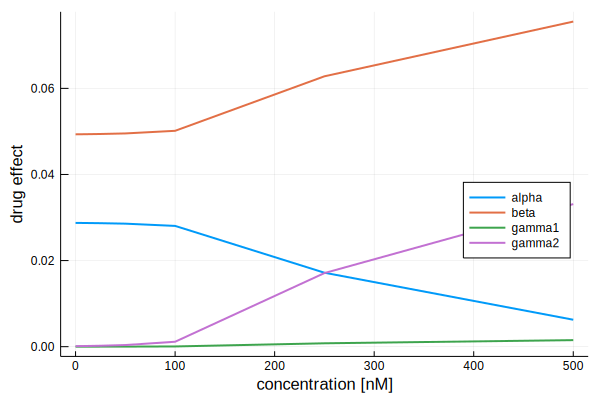

In [3]:
using Plots;
p = getDDEparams(pp, conc)
plot(conc, p[1, :], label = "alpha", linewidth = 2, xlabel = "concentration [nM]", ylabel = "drug effect")
plot!(conc, p[2, :], label = "beta", linewidth = 2, legend =:right)
plot!(conc, p[5, :], label = "gamma1", linewidth = 2)
plot!(conc, p[6, :], label = "gamma2", linewidth = 2)


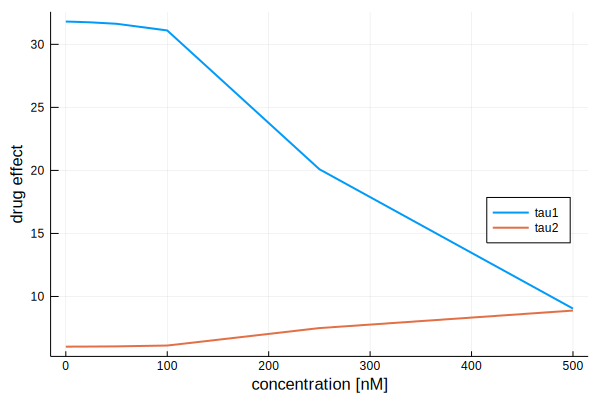

In [4]:
plot(conc, p[3, :], label = "tau1", linewidth = 2, xlabel = "concentration [nM]", ylabel = "drug effect")
plot!(conc, p[4, :], label = "tau2", linewidth = 2, legend =:right)

### Plot the data with the new set of parameters for DDE

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = plotIt(::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,1}, ::DataFrame, ::Int64, ::String) at plot.jl:32
└ @ Main /home/farnazm/dde/enhance/DrugResponseModel.jl/src/plot.jl:32


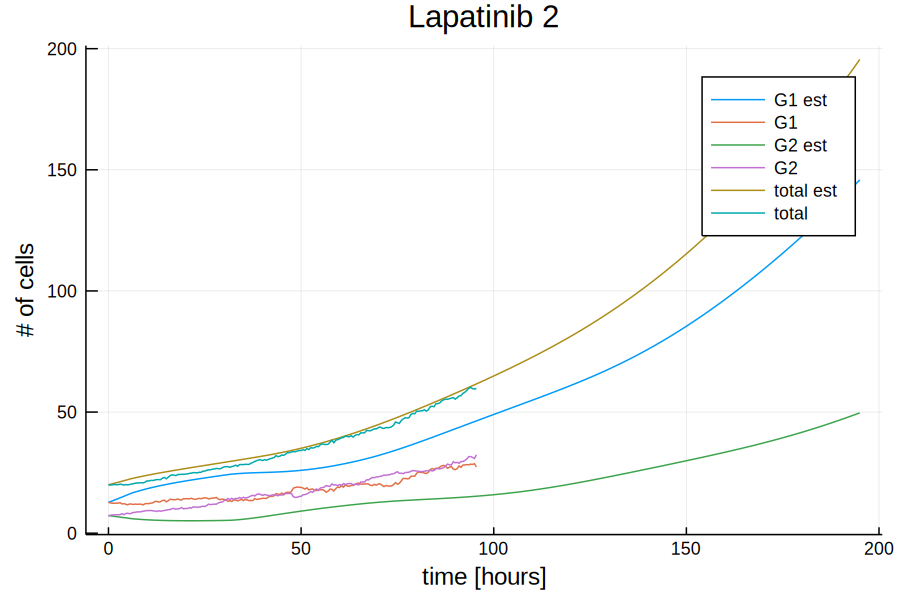

In [5]:
j = 2 # trial number
# for instance we want to plot the data and estimated for some trial 
plotIt(p[:, j], g1, g2, g1_0, g2_0, pop, j, "Lapatinib 2")

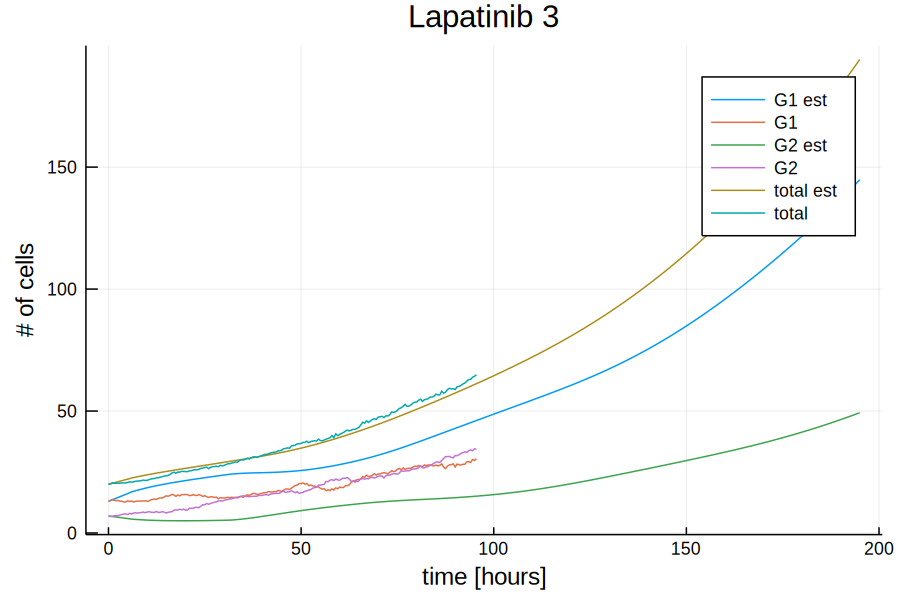

In [6]:
j = 3 # trial number
# for instance we want to plot the data and estimated for some trial 
plotIt(p[:, j], g1, g2, g1_0, g2_0, pop, j, "Lapatinib 3")

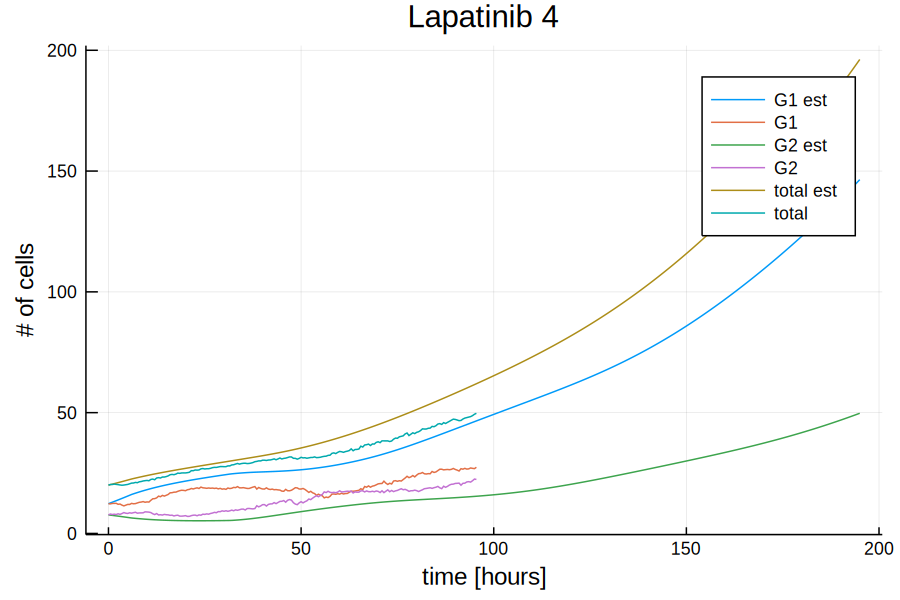

In [7]:
j = 4 # trial number
# for instance we want to plot the data and estimated for some trial 
plotIt(p[:, j], g1, g2, g1_0, g2_0, pop, j, "Lapatinib 4")

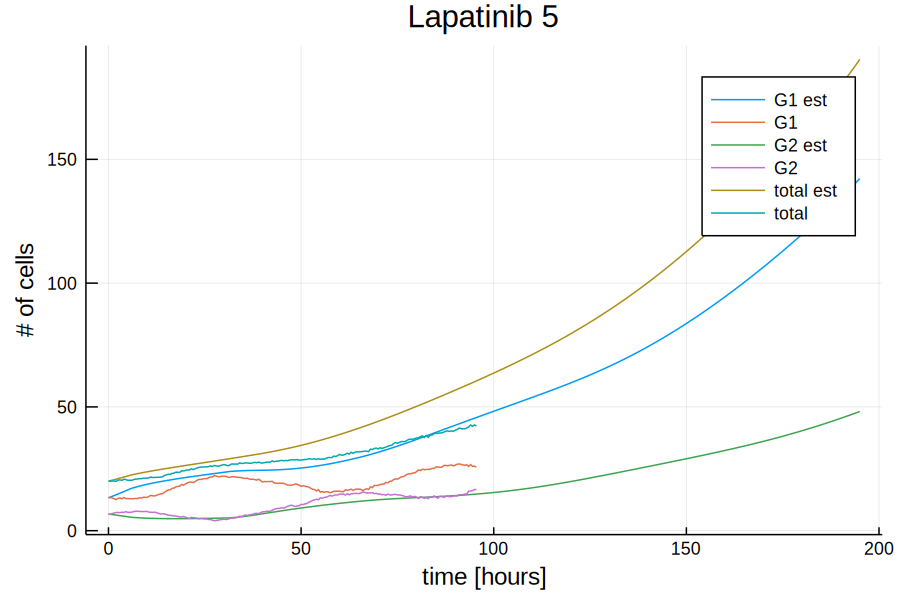

In [8]:
j = 5 # trial number
# for instance we want to plot the data and estimated for some trial 
plotIt(p[:, j], g1, g2, g1_0, g2_0, pop, j, "Lapatinib 5")

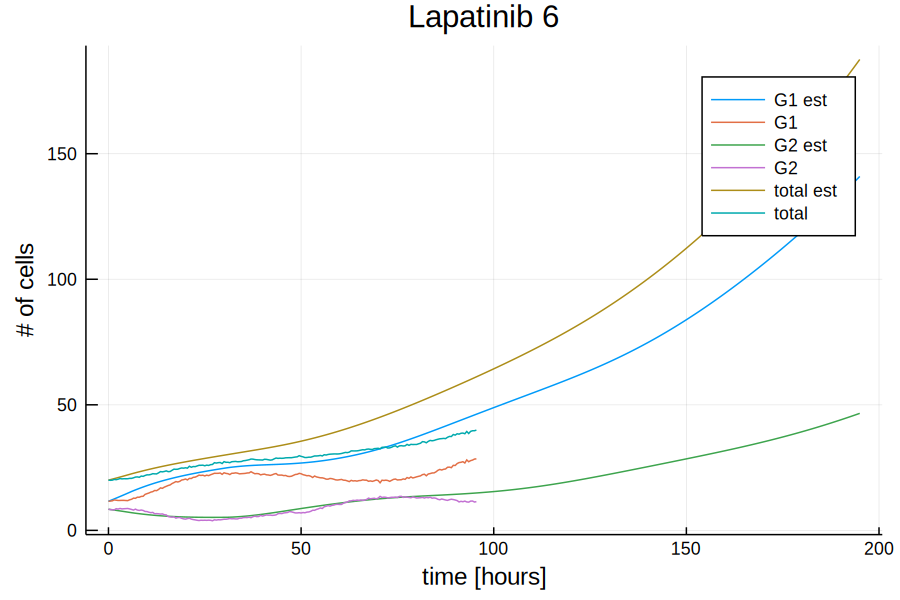

In [9]:
j = 6 # trial number
# for instance we want to plot the data and estimated for some trial 
plotIt(p[:, j], g1, g2, g1_0, g2_0, pop, j, "Lapatinib 6")

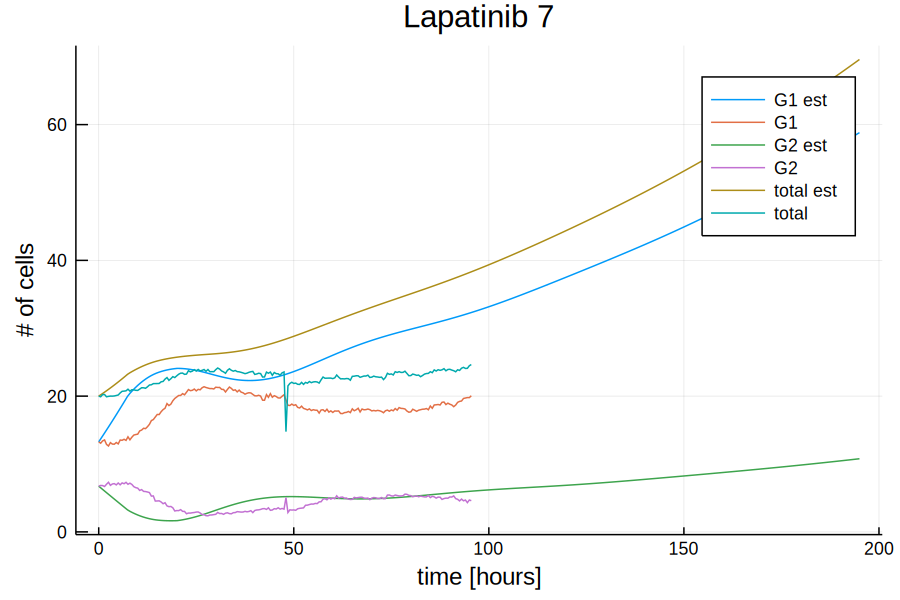

In [10]:
j = 7 # trial number
# for instance we want to plot the data and estimated for some trial 
plotIt(p[:, j], g1, g2, g1_0, g2_0, pop, j, "Lapatinib 7")

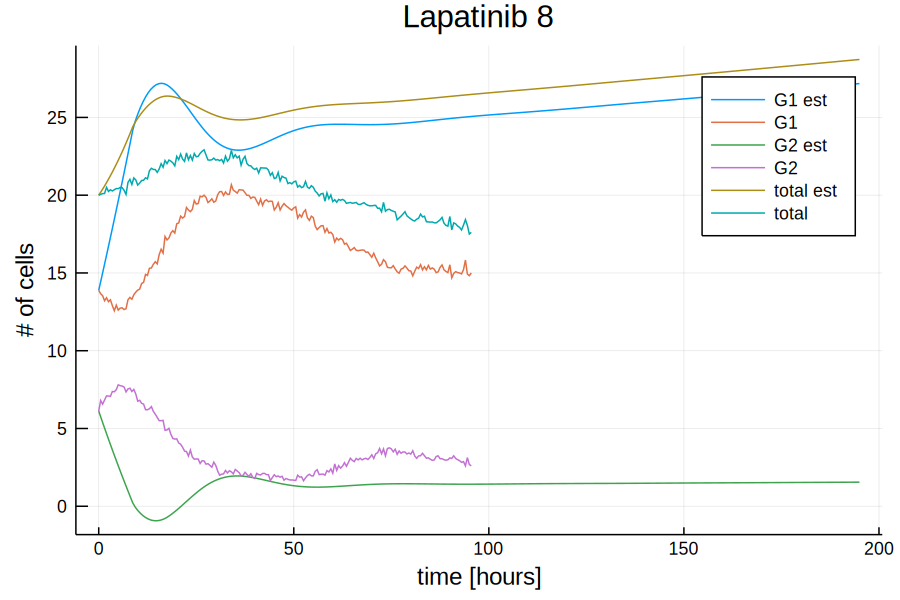

In [11]:
j = 8 # trial number
# for instance we want to plot the data and estimated for some trial 
plotIt(p[:, j], g1, g2, g1_0, g2_0, pop, j, "Lapatinib 8")